In [1]:
from utils_torch import *

proxy = torch_SpatioTemporalCO2()
device = proxy.check_torch_gpu()

train_dataloader, test_dataloader, train_dataset, test_dataset = proxy.make_dataloaders()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: Python39
Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080



In [2]:
model = proxy.trainer()

# Parameters: 484,674
Epoch: [10/100] | Loss: 0.0903 | Validation Loss: 0.0853
Epoch: [20/100] | Loss: 0.0774 | Validation Loss: 0.0738
Epoch: [30/100] | Loss: 0.0616 | Validation Loss: 0.0919
Epoch: [40/100] | Loss: 0.0659 | Validation Loss: 0.1671
Epoch: [50/100] | Loss: 0.0690 | Validation Loss: 0.0667
Epoch: [60/100] | Loss: 0.0602 | Validation Loss: 0.0566
Epoch: [70/100] | Loss: 0.0463 | Validation Loss: 0.0469
Epoch: [80/100] | Loss: 0.0473 | Validation Loss: 0.0485
Epoch: [90/100] | Loss: 0.0469 | Validation Loss: 0.0457
Epoch: [100/100] | Loss: 0.0449 | Validation Loss: 0.0476
Training finished.


In [3]:
x = torch.zeros((25,4,64,64)).to(device)
y = torch.zeros((25,60,2,64,64)).to(device)

for i in range(25):
    xt, yt = proxy.train_dataset[i]
    x[i] = xt
    y[i] = yt

y_train      = y.detach().cpu().numpy()
y_train_pred = model(x).cpu().detach().numpy()
print(y_train_pred.shape)
print(y_train.shape)

(25, 60, 2, 64, 64)
(25, 60, 2, 64, 64)


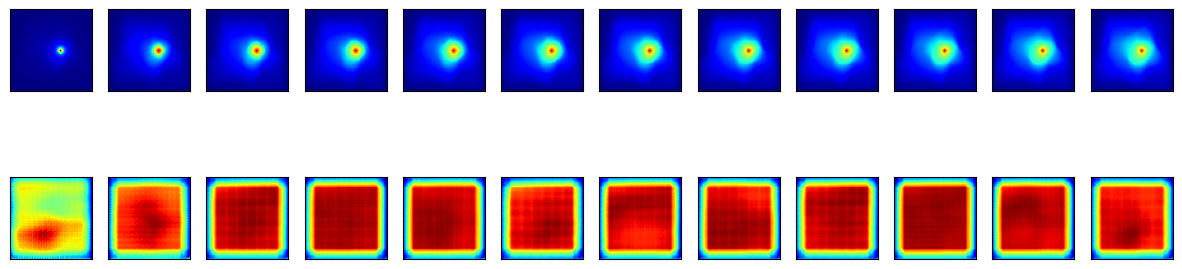

In [5]:
n = 0
c = 0

fig, axs = plt.subplots(2, 12, figsize=(15,4))
for j in range(12):
    axs[0,j].imshow(y_train[n,j*5,c], 'jet')
    axs[1,j].imshow(y_train_pred[n,j*5,c], 'jet')
    for i in range(2):
        axs[i,j].set(xticks=[], yticks=[])
plt.show()